# **Python Data Analysis Project <br> *Churn Project-Part B***

## Database - "BDA" & collection - "Customers"

In [537]:
# import PyMongo library 
import pymongo
import pandas as pd
from pymongo import MongoClient
from pandas import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) # --> show all columns of df


In [538]:
# connect to MongoDB , Database in MongoDB called "BDA", collection "Customers"     
client = MongoClient('mongodb://localhost:27017/')
type(client) # pymongo.mongo_client.MongoClient

client.list_database_names()
db = client['BDA']
type(db) # pymongo.database.Database
list(db.Customers.find())


[{'_id': ObjectId('664fa012b5b1126d875cc4e6'),
  'customerID': 'id7044',
  'gender': 'Male',
  'SeniorCitizen': 0,
  'Partner': 'Yes',
  'Dependents': 'No',
  'tenure': 15.2088514324,
  'Contract': 'Month-to-month',
  'PaperlessBilling': ['No'],
  'PaymentMethod': 'Credit card (automatic)',
  'MonthlyCharges': 45.6827820845,
  'TotalCharges': '651.55',
  'Services': {'PhoneService': 'Yes',
   'MultipleLines': 'No',
   'InternetService': 'DSL',
   'OnlineSecurity': 'No internet service',
   'OnlineBackup': 'Yes',
   'DeviceProtection': 'No internet service',
   'TechSupport': 'Yes',
   'StreamingTV': 'No',
   'StreamingMovies': 'Yes'}},
 {'_id': ObjectId('664fa012b5b1126d875cc4e7'),
  'customerID': 'id7045',
  'gender': 'Male',
  'SeniorCitizen': 0,
  'Partner': 'No',
  'Dependents': 'Yes',
  'tenure': 29.7799045784,
  'Contract': 'Month-to-month',
  'PaperlessBilling': ['Yes'],
  'PaymentMethod': 'Credit card (automatic)',
  'MonthlyCharges': 40.3015024676,
  'TotalCharges': '1359.7',


In [539]:
print(f'The collection has {len(list(db.Customers.find()))} customers')

The collection has 25000 customers


## Functions

### Printing Functions

In [540]:
def check(columns): # not services
    for col in columns:
        if(col=='PaperlessBilling'):
            if(len(list(db.Customers.find( {'PaperlessBilling' : [' ']})))>0):
                print(f'{col} have empty list')
            if(len(list(db.Customers.find( {'PaperlessBilling' : {'$exists': False}})))>0):
                print(f'{col} have empty list')        
        result1=db.Customers.find( {col : {'$exists': False}})
        result2=db.Customers.find( {col : ' '})   
        if(len(list(result1))>0):
            print(f'''{len(list(db.Customers.find( {col : {'$exists': False}})))} customers don't have {col}''')
        if(len(list(result2))>0):
            print(f'{col} have {len(list(db.Customers.find( {col : ' '})))} documents with empty string')
        if(col=='tenure'):
            if(len(list(db.Customers.find({'tenure': {'$lt':1}})))>0):
                print(f'There is {len(list(db.Customers.find({'tenure': {'$lt':1}})))} documents where {col}=0')



def check_sevices(service): # services
    for col in service:      
        result1=db.Customers.find( {f'Services.{col}' : {'$exists': False}})
        result2=db.Customers.find( {f'Services.{col}' : ' '})   
        if(len(list(result1))>0):
            print(f'''{len(list(db.Customers.find( {f'Services.{col}' : {'$exists': False}})))} customers have empty {col}''')
        if(len(list(result2))>0):
            print(f'{col} have {len(list(db.Customers.find( {f'Services.{col}' : ' '})))} documents with empty string')
        else:
            print(f'There is no documents with empty {col}')                           


### missing_values Function

In [541]:
def missing_values(data):
    df = pd.DataFrame(columns=['Variable', 'Unique values', 'Nan %', 'Zeros %', 'Empty %'])

    for col in data.columns:
        unique_values = data[col].nunique()
        nans = round(data[col].isnull().sum() / data.shape[0] * 100, 1)
        zeros = round((data[col] == 0).sum() / data.shape[0] * 100, 1)
        empty = round((data[col] == " ").sum() / data.shape[0] * 100, 1)  

        df.loc[len(df)] = [col, unique_values, nans, zeros, empty]  

    df = df.sort_values('Empty %', ascending=False)
    return df

### df_prep & predict Functions & Feature_Importances

In [542]:
# In part A, we removed tenure; however, we are not removing it here 
# because the correlation between TotalCharges and MonthlyCharges * tenure is almost zero (in part A, it was 99%)
def df_prep(df):
    df.columns = df.columns.str.lower()
  
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce').fillna(df['tenure'] * df['monthlycharges'])
    if 'churn' in df.columns:
        df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})
  

    customerid=df.customerid
    df=df.drop(columns=['customerid'], axis=1)
    
    # One-hot encode categorical variables
    df_dummies = pd.get_dummies(df)

    # Convert boolean columns to integers
    boolean_columns = df_dummies.select_dtypes(include='bool').columns
    df_dummies[boolean_columns] = df_dummies[boolean_columns].astype('int64')
    
    # Drop unnecessary columns
    drop_columns = [
        'multiplelines_No', 'onlinesecurity_Yes', 'onlinebackup_Yes', 'deviceprotection_Yes', 'techsupport_Yes',
        'partner_No', 'dependents_No', 'phoneservice_No', 'paperlessbilling_No',
        'streamingtv_No', 'streamingmovies_No', 'multiplelines_No phone service',
        'onlinesecurity_No internet service', 'onlinebackup_No internet service',
        'deviceprotection_No internet service', 'techsupport_No internet service',
        'streamingtv_No internet service', 'streamingmovies_No internet service']
    
    df_dummies.drop(columns=[col for col in drop_columns if col in df_dummies.columns], axis=1, inplace=True)
    
    # Combine features
    if {'partner_Yes', 'dependents_Yes'}.issubset(df_dummies.columns):
        df_dummies['partner_Dependents'] = df_dummies[['partner_Yes', 'dependents_Yes']].sum(axis=1)
        df_dummies.drop(['partner_Yes', 'dependents_Yes'], axis=1, inplace=True)
    
    if {'streamingtv_Yes', 'streamingmovies_Yes'}.issubset(df_dummies.columns):
        df_dummies['StreamingServices'] = df_dummies['streamingtv_Yes']+df_dummies['streamingmovies_Yes']
        df_dummies.drop(['streamingtv_Yes', 'streamingmovies_Yes'], axis=1, inplace=True)
    
    if {'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)'}.issubset(df_dummies.columns):
        df_dummies['PaymentMethod_automatic'] = df_dummies[['paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)']].sum(axis=1)
        df_dummies.drop(columns=['paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check', 'paymentmethod_Mailed check'], axis=1, inplace=True)
  
    if 'internetservice_no' in df_dummies.columns:
        df_dummies['Additional_Services'] = (
            (1 - df_dummies['onlinesecurity_No']) +
            (1 - df_dummies['onlinebackup_No']) +
            (1 - df_dummies['deviceprotection_No']) +
            (1 - df_dummies['techsupport_No']) +
            df_dummies['StreamingServices'] +
            (1 - df_dummies['internetservice_No']))
        
        df_dummies.loc[df_dummies['internetservice_No'] == 1, 'Additional_Services'] = 0
        df_dummies['Additional_Services'] = df_dummies['Additional_Services'].astype('int64')

    df_dummies=df_dummies.join(customerid)
    df_dummies.columns = df_dummies.columns.str.lower()

    if 'churn' in df_dummies.columns:
        df_dummies=df_dummies[['seniorcitizen', 'monthlycharges', 'totalcharges', 
       'gender_female', 'gender_male', 'phoneservice_yes', 'multiplelines_yes',
       'internetservice_dsl', 'internetservice_fiber optic',
       'internetservice_no', 'onlinesecurity_no', 'onlinebackup_no',
       'deviceprotection_no', 'techsupport_no', 'contract_month-to-month',
       'contract_one year', 'contract_two year', 'paperlessbilling_yes',
       'partner_dependents', 'streamingservices', 'paymentmethod_automatic','tenure',
       'customerid','churn']]
    else:
        df_dummies=df_dummies[['seniorcitizen', 'monthlycharges', 'totalcharges', 
       'gender_female', 'gender_male', 'phoneservice_yes', 'multiplelines_yes',
       'internetservice_dsl', 'internetservice_fiber optic',
       'internetservice_no', 'onlinesecurity_no', 'onlinebackup_no',
       'deviceprotection_no', 'techsupport_no', 'contract_month-to-month',
       'contract_one year', 'contract_two year', 'paperlessbilling_yes',
       'partner_dependents', 'streamingservices', 'paymentmethod_automatic','tenure',
       'customerid']]           
        
    return  df_dummies




def predict(x_train,y_train,x_test,Customers):    
    from sklearn.ensemble import RandomForestClassifier # Importing the algorithm
    from sklearn.metrics import accuracy_score # importing "accuracy_score" from "sklearn.metrics"
    model = RandomForestClassifier(n_estimators=43, max_depth=25, random_state=1)
    model.fit(x_train, y_train)
    y_test_pred_RandomForest=model.predict(x_test)
    output = pd.DataFrame({'customerid': Customers.customerid, 'y_test_pred_RandomForest': y_test_pred_RandomForest}) # saving results to DataFrame
    Customers_prd=Customers.join(output.y_test_pred_RandomForest).rename({'y_test_pred_RandomForest':'churn'},axis=1)
    Customers_prd=Customers_prd[['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure','phoneservice', 'multiplelines','internetservice',
                            'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
                            'monthlycharges', 'totalcharges','churn']]

    Customers_prd.columns=pd.read_csv('churn.csv').columns

    Customers_prd.TotalCharges=Customers_prd.TotalCharges.astype(str)
    Customers_prd.tenure =Customers_prd.tenure .astype('int64')
    Customers_prd.Churn =Customers_prd.Churn.map({0:'No',1:'Yes'})
    return Customers_prd

def Feature_Importances(x_train,y_train,x_test,Customers): 
    from sklearn.ensemble import RandomForestClassifier # Importing the algorithm
    model = RandomForestClassifier(n_estimators=43, max_depth=25, random_state=1)   
    model.fit(x_train, y_train)
    feature_importances = model.feature_importances_ # applying the method "feature_importances_" on the algorithm
    feature_importances # Every feature importance (%)
    features = x_train.columns # all the features
    stats = pd.DataFrame({'feature':features, 'importance':feature_importances}) # creating the data frame
    stats.sort_values('importance', ascending=False) # Sorting the data frame
    stats_sort = stats.sort_values('importance', ascending=False)
    return stats_sort


## checking Customers collection and printing

In [543]:
columns=['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges','PaperlessBilling']
check(columns)
service=['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']
check_sevices(service)

There is 112 documents where tenure=0
1577 customers don't have PaymentMethod
TotalCharges have 5 documents with empty string
There is no documents with empty PhoneService
There is no documents with empty MultipleLines
There is no documents with empty InternetService
There is no documents with empty OnlineSecurity
There is no documents with empty OnlineBackup
There is no documents with empty DeviceProtection
There is no documents with empty TechSupport
There is no documents with empty StreamingTV
There is no documents with empty StreamingMovies


In [544]:
# checking TotalCharges -  we will remove 5 documents with empty string  
list(db.Customers.find( {'TotalCharges' : ' '},{'TotalCharges':1,'MonthlyCharges':1,'tenure':1,'_id':0}))

[{'tenure': 22.9003472081,
  'MonthlyCharges': 46.7151055604,
  'TotalCharges': ' '},
 {'tenure': 48.5648893183,
  'MonthlyCharges': 69.8904466493,
  'TotalCharges': ' '},
 {'tenure': 18.0750507527,
  'MonthlyCharges': 57.3280908633,
  'TotalCharges': ' '},
 {'tenure': 47.0617990964,
  'MonthlyCharges': 93.9651906338,
  'TotalCharges': ' '},
 {'tenure': 28.0742999983,
  'MonthlyCharges': 87.0612003446,
  'TotalCharges': ' '}]

In [545]:
result=db.Customers.find( {'PaymentMethod' : {'$exists': True},'TotalCharges' : {'$ne':' '}},{'_id':0}) 
print(f'{len(list(result))} customers that have all the fields')

23418 customers that have all the fields


## Use MongoDB Compass to analyze the scheme and import the collection to Pandas DataFrame and checking missing values and duplicate


* **PaymentMethod** have 6% documents without these field- remove these documents
* **Services** - Document with 9 nested fields- after json_normalize we "fix" the columns name
* **tenure** - 0.6% of the documents is integer type
* **TotalCharges**- is string- remove empty string becuse it's only 5 documents
* **PaperlessBilling**- Array lengths size 1 with average: 1.0 with string 'Yes' or 'No'- we convert list to string


In [546]:
# Only documents that have all the fields and all the fields except "_id"- 

document = db.Customers.find_one()

if document:
    column_names = list(document.keys())

    conditions = [{column: {'$exists': True, '$ne': ' '}} for column in column_names]

    # Perform the query and save the results in a list
    list_cur = list(db.Customers.find({'$and': conditions}, {'_id': 0}))


In [547]:

Customers = json_normalize(list_cur) # import the collection to Pandas DataFrame
Customers.isnull().sum().sum() # not have null
Customers.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Services.PhoneService',
       'Services.MultipleLines', 'Services.InternetService',
       'Services.OnlineSecurity', 'Services.OnlineBackup',
       'Services.DeviceProtection', 'Services.TechSupport',
       'Services.StreamingTV', 'Services.StreamingMovies'],
      dtype='object')

In [548]:
# change Services columns name
Customers.columns = [field.split('.')[1] if field.startswith('Services.') else field for field in Customers.columns]

# PaperlessBilling- handling list type 

Customers.PaperlessBilling=pd.Series(Customers.PaperlessBilling).apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x) 
Customers.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,id7044,Male,0,Yes,No,15.208851,Month-to-month,No,Credit card (automatic),45.682782,651.55,Yes,No,DSL,No internet service,Yes,No internet service,Yes,No,Yes
1,id7045,Male,0,No,Yes,29.779905,Month-to-month,Yes,Credit card (automatic),40.301502,1359.7,No,Yes,DSL,No internet service,Yes,Yes,No internet service,Yes,Yes
2,id7046,Female,0,Yes,Yes,34.546357,Month-to-month,Yes,Mailed check,59.778062,1752.55,Yes,No,DSL,Yes,No,Yes,No,No internet service,No internet service
3,id7047,Male,0,No,No,37.264434,Month-to-month,Yes,Electronic check,58.392744,541.9,Yes,Yes,DSL,Yes,No,Yes,No internet service,No,Yes
4,id7049,Female,1,No,No,31.188870,Two year,No,Bank transfer (automatic),87.322896,845.6,Yes,Yes,Fiber optic,No,Yes,Yes,No internet service,No internet service,No


In [549]:
# checking missing values and duplicate (23418 customers- not duclicate)
result = missing_values(Customers) 
result 

,Variable,Unique values,Nan %,Zeros %,Empty %
0,customerID,23418,0.0,0.0,0.0
1,gender,2,0.0,0.0,0.0
18,StreamingTV,3,0.0,0.0,0.0
17,TechSupport,3,0.0,0.0,0.0
16,DeviceProtection,3,0.0,0.0,0.0
15,OnlineBackup,3,0.0,0.0,0.0
14,OnlineSecurity,3,0.0,0.0,0.0
13,InternetService,3,0.0,0.0,0.0
12,MultipleLines,3,0.0,0.0,0.0
11,PhoneService,2,0.0,0.0,0.0


## PREP- telecom_dummies  & Customers_dummies

In [550]:

telecom_dummies=df_prep(pd.read_csv('churn.csv')) # we analyze this df in part A
Customers_dummies= df_prep(Customers)

Customers_dummies


,seniorcitizen,monthlycharges,totalcharges,gender_female,gender_male,phoneservice_yes,multiplelines_yes,internetservice_dsl,internetservice_fiber optic,internetservice_no,onlinesecurity_no,onlinebackup_no,deviceprotection_no,techsupport_no,contract_month-to-month,contract_one year,contract_two year,paperlessbilling_yes,partner_dependents,streamingservices,paymentmethod_automatic,tenure,customerid
0,0,45.682782,651.55,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,15.208851,id7044
1,0,40.301502,1359.70,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,2,1,29.779905,id7045
2,0,59.778062,1752.55,1,0,1,0,1,0,0,0,1,0,1,1,0,0,1,2,0,0,34.546357,id7046
3,0,58.392744,541.90,0,1,1,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,37.264434,id7047
4,1,87.322896,845.60,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,31.188870,id7049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23413,0,91.817322,867.30,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,10.304650,id32038
23414,0,71.692238,7962.20,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,0,0,15.826004,id32039
23415,0,86.958880,374.80,0,1,1,1,0,1,0,0,0,1,0,0,1,0,1,1,1,0,33.852572,id32040
23416,0,76.120814,238.15,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,2,0,0,33.154407,id32041


## Prediction & CSV

In [551]:
x_train = telecom_dummies.drop(columns=['churn','customerid'], axis=1)
y_train = telecom_dummies['churn']
x_test=Customers_dummies.drop(columns='customerid',axis=1)

Customers_prd =predict(x_train,y_train,x_test,Customers)

Customers_prd.to_csv('Customers.csv', index=False) # saving results to csv


### Feature_Importances

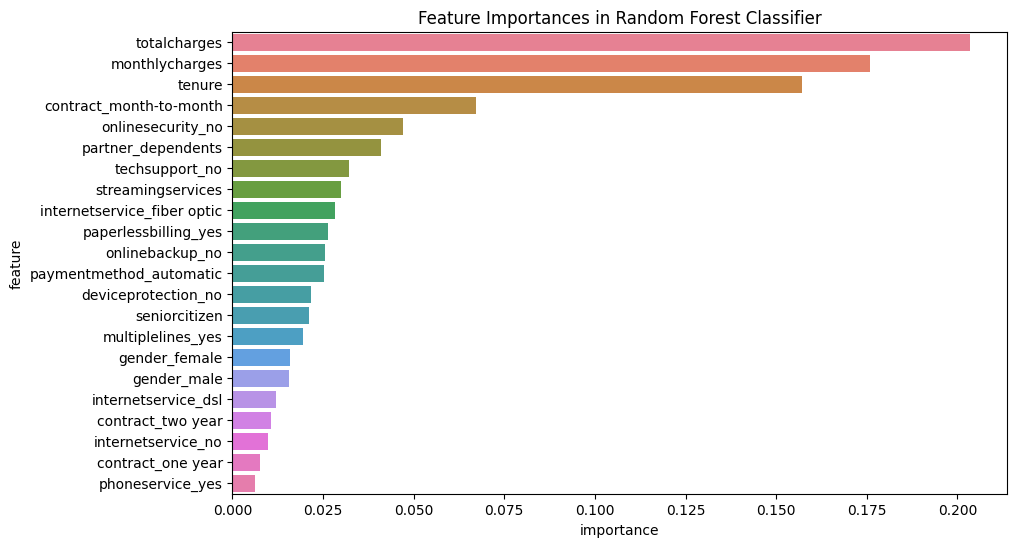

In [552]:
FI=Feature_Importances(x_train,y_train,x_test,Customers)


plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=FI, hue='feature', dodge=False)
plt.title('Feature Importances in Random Forest Classifier')
plt.show()

### Percentage of Churn in the given Data

We have 23418 customers but only 630 of them churn!! 2.7% 


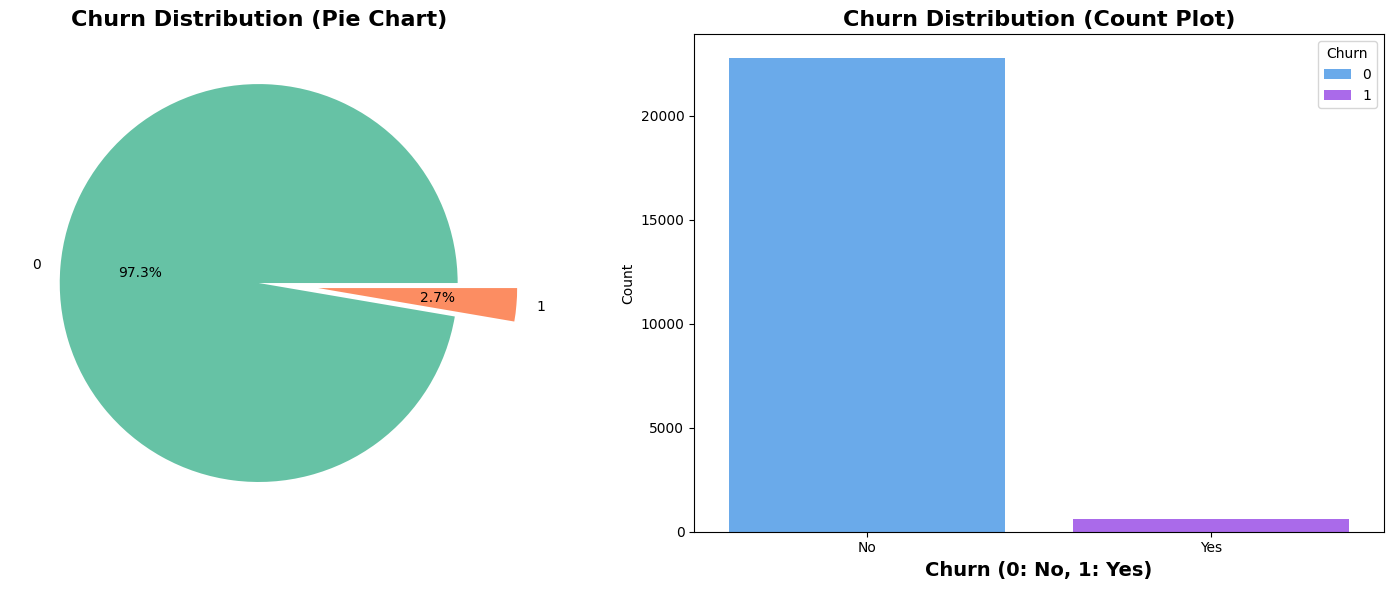

Churn
0    22788
1      630
Name: count, dtype: Int64

In [553]:
Customers=pd.read_csv('Customers.csv')
Customers.Churn=Customers.Churn.map({'Yes':1, 'No':0}).astype('Int64')

churn_dist = Customers.Churn.value_counts(normalize=True)

churn_dist
print(f"We have {len(Customers)} customers but only {Customers.Churn.sum()} of them churn!! {((Customers.Churn.sum()/len(Customers))*100):.1f}% ")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].pie(churn_dist, labels=churn_dist.index, autopct='%1.1f%%', explode=[0, 0.3], colors=['#66c2a5', '#fc8d62'])
axs[0].set_title('Churn Distribution (Pie Chart)',fontsize=16, fontweight='bold')
axs[0].set_ylabel('')


sns.countplot(x='Churn', data=Customers, palette='cool', ax=axs[1], hue='Churn')
axs[1].set_title("Churn Distribution (Count Plot)",fontsize=16, fontweight='bold')
axs[1].set_xlabel("Churn (0: No, 1: Yes)",fontsize=14, fontweight='bold')
axs[1].set_ylabel("Count", fontsize=10)
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['No', 'Yes'])


plt.tight_layout()
plt.show()
Customers.Churn.value_counts()



